In [1]:
import gymnasium as gym
import numpy as np
import random
import math
import time
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
env = gym.make("CartPole-v1")

In [3]:
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, transition):
        self.buffer.append(transition)
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, input_dim=4, hidden1=24, hidden2=32, output_dim=2):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, env, memory_capacity=5000, batch_size=128,
                 gamma=0.99, lr=0.0005, target_update=10,
                 epsilon_start=1.0, epsilon_end=0.001, epsilon_decay=0.995):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.target_update = target_update
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.policy_net = DQN(output_dim=env.action_space.n).to(self.device)
        self.target_net = DQN(output_dim=env.action_space.n).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.memory = ReplayMemory(memory_capacity)
        self.steps_done = 0

    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                return self.policy_net(state_tensor).argmax().item()

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)

        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + self.gamma * next_q_values * (~dones)

        loss = nn.functional.mse_loss(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, num_episodes=500, max_steps=500, model_save_path="a2_part_2_dqn_cartpole_shrutili_omjagatr.pth"):
        rewards_per_episode = []
        epsilon_per_episode = []
        best_avg = -float("inf")

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            state = np.array(state, dtype=np.float32)
            total_reward = 0

            for step in range(max_steps):
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_state = np.array(next_state, dtype=np.float32)

                self.memory.push((state, action, reward, next_state, done))
                state = next_state
                total_reward += reward

                self.optimize_model()

                if done:
                    break

            rewards_per_episode.append(total_reward)
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
            epsilon_per_episode.append(self.epsilon)

            if episode % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            avg_recent = np.mean(rewards_per_episode[-10:])
            if avg_recent > best_avg and avg_recent >= 480:
                best_avg = avg_recent
                self.save_model(model_save_path)
                print(f"Solved Environment: Episode {episode}, Avg Reward of last 10 episodes: {avg_recent:.2f}")
                break

            if episode % 10 == 0:
                print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {self.epsilon:.3f}")

        return rewards_per_episode, epsilon_per_episode

    def save_model(self, filename="a2_part_2_dqn_cartpole_shrutili_omjagatr.pth"):
        torch.save(self.policy_net.state_dict(), filename)

    def load_model(self, filename="a2_part_2_dqn_cartpole_shrutili_omjagatr.pth"):
        self.policy_net.load_state_dict(torch.load(filename))
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [4]:
agent = DQNAgent(env)
rewards, epsilons = agent.train(num_episodes=2000)

Episode 0, Reward: 26.0, Epsilon: 0.995


<ipython-input-3-c37557d15ceb>:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.tensor(states, dtype=torch.float32, device=self.device)


Episode 10, Reward: 60.0, Epsilon: 0.946
Episode 20, Reward: 13.0, Epsilon: 0.900
Episode 30, Reward: 57.0, Epsilon: 0.856
Episode 40, Reward: 25.0, Epsilon: 0.814
Episode 50, Reward: 31.0, Epsilon: 0.774
Episode 60, Reward: 29.0, Epsilon: 0.737
Episode 70, Reward: 9.0, Epsilon: 0.701
Episode 80, Reward: 36.0, Epsilon: 0.666
Episode 90, Reward: 32.0, Epsilon: 0.634
Episode 100, Reward: 144.0, Epsilon: 0.603
Episode 110, Reward: 124.0, Epsilon: 0.573
Episode 120, Reward: 307.0, Epsilon: 0.545
Episode 130, Reward: 197.0, Epsilon: 0.519
Episode 140, Reward: 121.0, Epsilon: 0.493
Episode 150, Reward: 293.0, Epsilon: 0.469
Episode 160, Reward: 50.0, Epsilon: 0.446
Episode 170, Reward: 287.0, Epsilon: 0.424
Episode 180, Reward: 191.0, Epsilon: 0.404
Episode 190, Reward: 284.0, Epsilon: 0.384
Episode 200, Reward: 411.0, Epsilon: 0.365
Episode 210, Reward: 238.0, Epsilon: 0.347
Episode 220, Reward: 317.0, Epsilon: 0.330
Episode 230, Reward: 192.0, Epsilon: 0.314
Episode 240, Reward: 159.0, Eps

> Epsilon Decay Graph

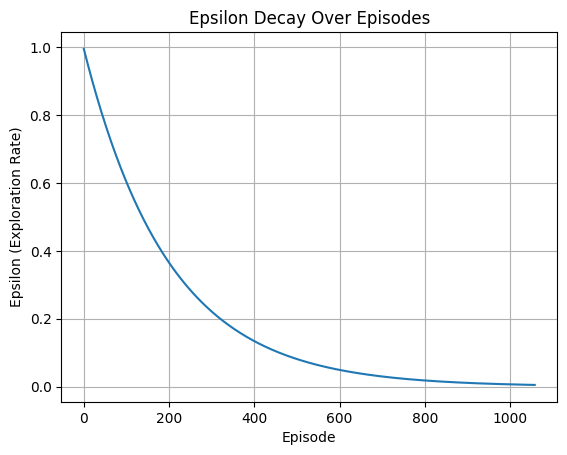

In [17]:
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon (Exploration Rate)")
plt.title("Epsilon Decay Over Episodes")
plt.grid(True)
plt.show()

> Total Rewards per Epsiode

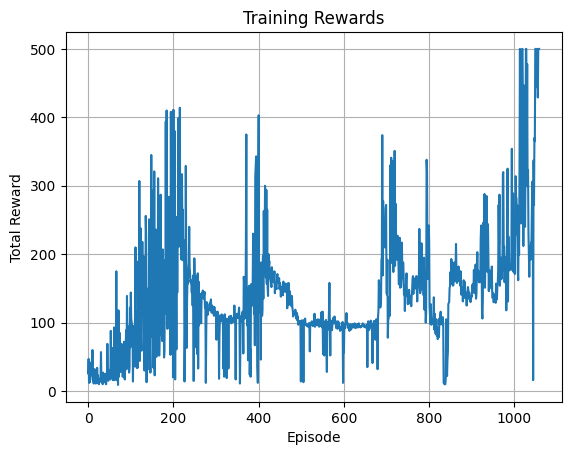

In [6]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards")
plt.grid(True)
plt.show()

> Running the agent for 10 episodes, where
the agent chooses only greedy actions from the learnt policy.

In [16]:
agent.load_model("a2_part_2_gridworld_shrutili_omjagatr")
eval_rewards = []
print("Greedy Policy Evaluation")
for episode in range(10):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.device)
        with torch.no_grad():
            action = agent.policy_net(state_tensor).argmax().item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward
        done = terminated or truncated
    eval_rewards.append(total_reward)
    print(f"Episode {episode+1}, Total Reward: {total_reward}")

Greedy Policy Evaluation
Episode 1, Total Reward: 500.0
Episode 2, Total Reward: 500.0
Episode 3, Total Reward: 500.0
Episode 4, Total Reward: 500.0
Episode 5, Total Reward: 500.0
Episode 6, Total Reward: 500.0
Episode 7, Total Reward: 500.0
Episode 8, Total Reward: 500.0
Episode 9, Total Reward: 500.0
Episode 10, Total Reward: 500.0


> Total Reward per Episode for Evaluation

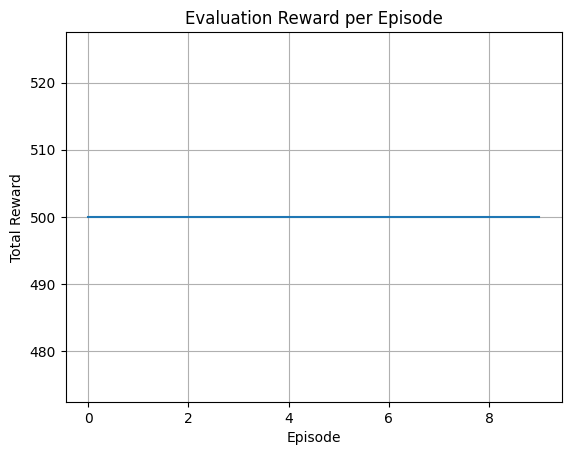

In [14]:
plt.plot(eval_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Evaluation Reward per Episode")
plt.grid(True)
plt.show()

> 1 episode where the agent chooses only
greedy actions from the learned policy

In [10]:
agent.load_model("a2_part_2_dqn_cartpole_shrutili_omjagatr.pth")
state, _ = env.reset()
state = np.array(state, dtype=np.float32)
done = False
total_reward = 0
step = 0
while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():
        action = agent.policy_net(state_tensor).argmax().item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = np.array(next_state, dtype=np.float32)

    print(f"Step {step}: State = {np.round(state, 3)}, Action = {action}, Reward = {reward}")
    state = next_state
    total_reward += reward
    done = terminated or truncated
    step += 1
env.close()
print(f"\nGreedy Episode Total Reward: {total_reward}")

Step 0: State = [0.04  0.047 0.012 0.026], Action = 1, Reward = 1.0
Step 1: State = [ 0.041  0.242  0.013 -0.263], Action = 1, Reward = 1.0
Step 2: State = [ 0.046  0.437  0.007 -0.551], Action = 1, Reward = 1.0
Step 3: State = [ 0.054  0.632 -0.004 -0.842], Action = 1, Reward = 1.0
Step 4: State = [ 0.067  0.827 -0.02  -1.136], Action = 1, Reward = 1.0
Step 5: State = [ 0.083  1.022 -0.043 -1.435], Action = 0, Reward = 1.0
Step 6: State = [ 0.104  0.828 -0.072 -1.156], Action = 0, Reward = 1.0
Step 7: State = [ 0.12   0.634 -0.095 -0.886], Action = 0, Reward = 1.0
Step 8: State = [ 0.133  0.44  -0.113 -0.625], Action = 0, Reward = 1.0
Step 9: State = [ 0.142  0.247 -0.125 -0.37 ], Action = 0, Reward = 1.0
Step 10: State = [ 0.147  0.053 -0.133 -0.119], Action = 1, Reward = 1.0
Step 11: State = [ 0.148  0.25  -0.135 -0.451], Action = 0, Reward = 1.0
Step 12: State = [ 0.153  0.057 -0.144 -0.203], Action = 0, Reward = 1.0
Step 13: State = [ 0.154 -0.136 -0.148  0.041], Action = 0, Rewar